## PROBLEM STATEMENT:
- This project focuses on the Kaggle Histopathologic Cancer Detection challenge. The main objective is to develop a machine learning model that can automatically detect metastatic cancer in small image patches extracted from large digital pathology scans. These scans show sections of lymph node tissue, and the task is to correctly classify whether each patch contains cancerous cells or not. The aim is to assist pathologists by improving the accuracy and efficiency of cancer detection through automated image analysis.

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import random
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random

print(f"PyTorch Version: {torch.__version__}")

PyTorch Version: 2.8.0


In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.mps.manual_seed(seed)

In [3]:
data_dir = 'histopathologic-cancer-detection'
train_labels = pd.read_csv(f'{data_dir}/train_labels.csv')
train_dir = os.path.join(data_dir, 'train')

### Dataset Balance Check

Just checking how balanced the dataset is before training.  

Looks like there are a bit more normal images than tumor ones (around 1:1.47 ratio).

The imbalance isn’t too bad, not severely imbalanced.


In [4]:
print(f"Total training data: {len(train_labels):,}")
print(f"Positive (Tumor): {train_labels['label'].sum():,} ({train_labels['label'].mean()*100:.2f}%)")
print(f"Negative (Normal): {(1-train_labels['label']).sum():,} ({(1-train_labels['label'].mean())*100:.2f}%)")
imbalance_ratio = (1-train_labels['label'].mean())/train_labels['label'].mean()
print(f"Class Imbalance Ratio = 1:{imbalance_ratio:.2f}")

Total training data: 220,025
Positive (Tumor): 89,117 (40.50%)
Negative (Normal): 130,908 (59.50%)
Class Imbalance Ratio = 1:1.47


## The visualization of class distribution

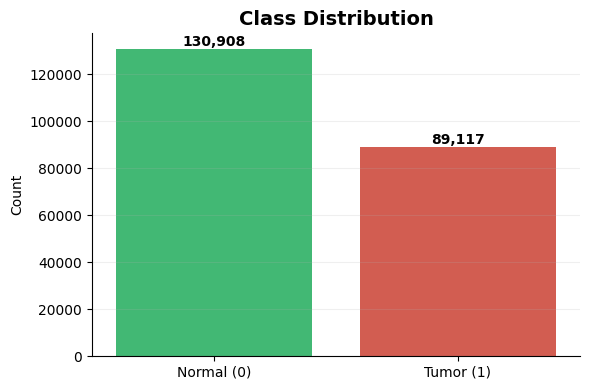

In [5]:
class_counts = train_labels['label'].value_counts().sort_index()
classes = ['Normal (0)', 'Tumor (1)']

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=classes, y=class_counts.values, palette=['#2ecc71', '#e74c3c'])

for i, count in enumerate(class_counts.values):
    ax.text(i, count, f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=10)
plt.xlabel('')
plt.grid(axis='y', alpha=0.2)
sns.despine(top=True, right=True)

plt.tight_layout()
plt.show()

## Performing PCA visualization

From the PCA analysis and t-SNE analysis, the linear nature of PCA cannot fully distinguish the two classes, means the feature space contains non-linear relationships, there is no simple way to distinguish the two classes with normal and tumor.

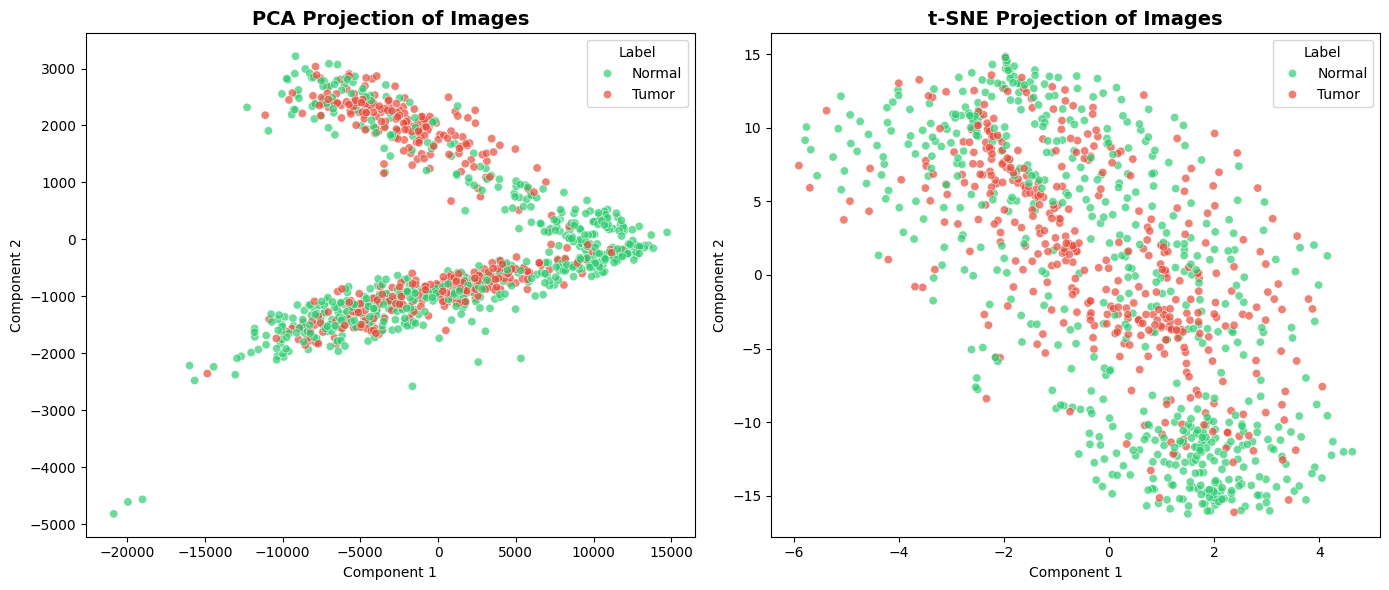

In [6]:

# Sample 1000 random images
sample_subset = train_labels.sample(1000, random_state=42)
sample_images = []
for img_id in sample_subset['id']:
    img_path = os.path.join(train_dir, f"{img_id}.tif")
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    sample_images.append(img)
sample_images = np.stack(sample_images)

flattened = sample_images.reshape(1000, -1)

# Dimensionality reduction
pca = PCA(n_components=2).fit_transform(flattened)
tsne = TSNE(
    n_components=2,
    learning_rate='auto',
    init='random',
    perplexity=30,
    random_state=42
).fit_transform(flattened)

label_names = sample_subset['label'].map({0: 'Normal', 1: 'Tumor'})

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(
    x=pca[:, 0], y=pca[:, 1],
    hue=label_names,
    palette={'Normal': '#2ecc71', 'Tumor': '#e74c3c'},
    alpha=0.7, ax=axes[0]
)
axes[0].set_title('PCA Projection of Images', fontsize=14, fontweight='bold')

sns.scatterplot(
    x=tsne[:, 0], y=tsne[:, 1],
    hue=label_names,
    palette={'Normal': '#2ecc71', 'Tumor': '#e74c3c'},
    alpha=0.7, ax=axes[1]
)
axes[1].set_title('t-SNE Projection of Images', fontsize=14, fontweight='bold')

for ax in axes:
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.legend(title='Label')

plt.tight_layout()
plt.show()


## Pixel Intensity Distribution Analysis

This visualization compares pixel intensity distributions between normal and tumor tissue across RGB channels in histopathology images.

Blue channel and brightness show the largest differences between Normal and Tumor images.

The blue channe reveals the major difference for tumor and normal images, where tumor tissue demonstrates substantially elevated blue intensity with a narrower distribution peak, indicating stronger blue component absorption or reflection in cancerous areas.

We may leverage this feature for image classification.

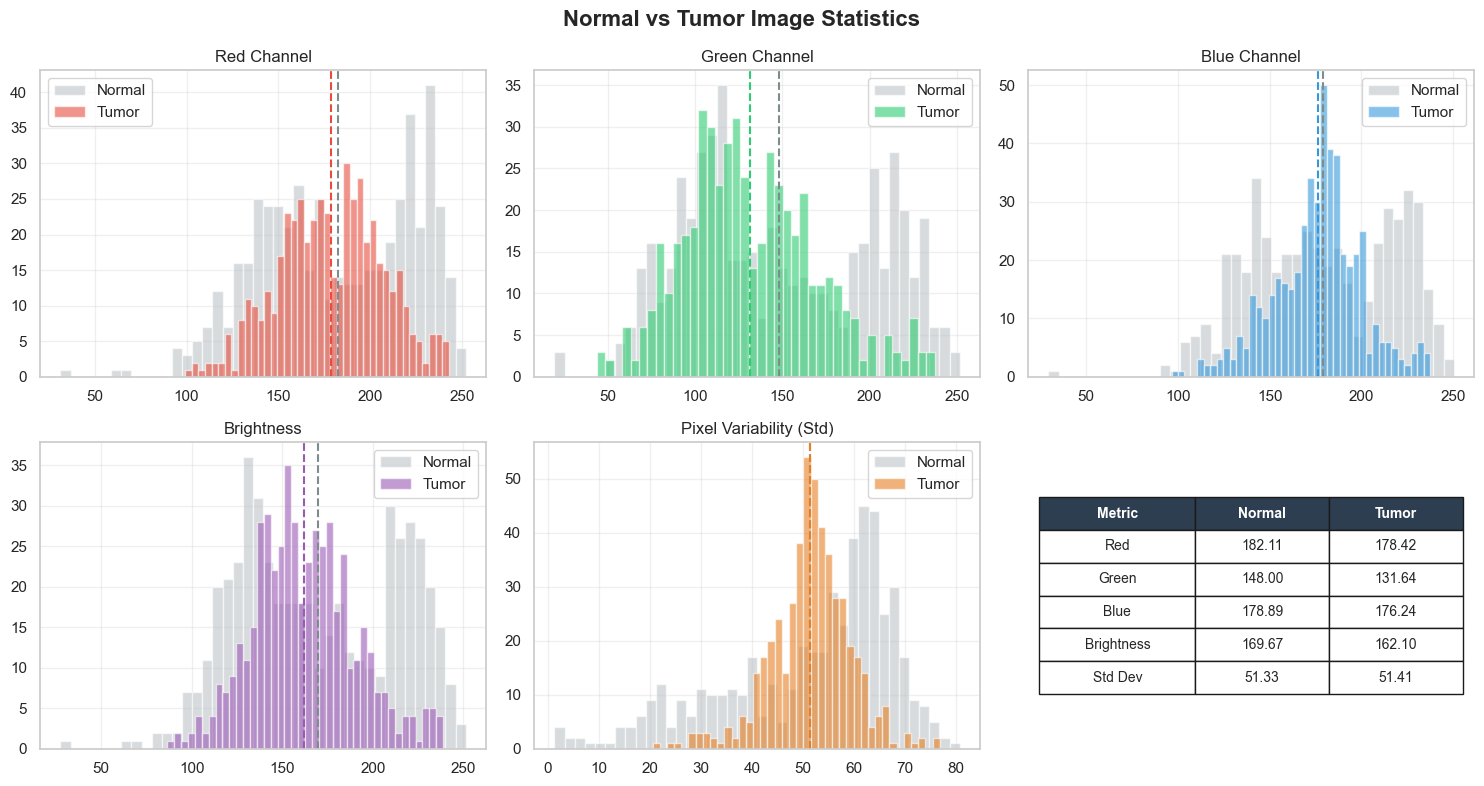

In [32]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

sample_size = 500
sample_normal = train_labels[train_labels['label'] == 0].sample(sample_size, random_state=42)
sample_tumor = train_labels[train_labels['label'] == 1].sample(sample_size, random_state=42)

def get_image_stats(df):
    stats = {'red': [], 'green': [], 'blue': [], 'brightness': [], 'std': []}
    for img_id in df['id']:
        img_path = os.path.join(train_dir, f"{img_id}.tif")
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        stats['red'].append(img[:,:,0].mean())
        stats['green'].append(img[:,:,1].mean())
        stats['blue'].append(img[:,:,2].mean())
        stats['brightness'].append(img.mean())
        stats['std'].append(img.std())
    return stats

normal_stats = get_image_stats(sample_normal)
tumor_stats = get_image_stats(sample_tumor)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Normal vs Tumor Image Statistics', fontsize=16, fontweight='bold')

def plot_hist(ax, key, color, title):
    ax.hist(normal_stats[key], bins=40, alpha=0.6, label='Normal', color='#bdc3c7')
    ax.hist(tumor_stats[key], bins=40, alpha=0.6, label='Tumor', color=color)
    ax.axvline(np.mean(normal_stats[key]), color='#7f8c8d', linestyle='--')
    ax.axvline(np.mean(tumor_stats[key]), color=color, linestyle='--')
    ax.set_title(title)
    ax.legend()
    ax.grid(alpha=0.3)

plot_hist(axes[0,0], 'red', '#e74c3c', 'Red Channel')
plot_hist(axes[0,1], 'green', '#2ecc71', 'Green Channel')
plot_hist(axes[0,2], 'blue', '#3498db', 'Blue Channel')
plot_hist(axes[1,0], 'brightness', '#9b59b6', 'Brightness')
plot_hist(axes[1,1], 'std', '#e67e22', 'Pixel Variability (Std)')

# Summary table
ax = axes[1,2]
ax.axis('off')
summary = [
    ['Metric', 'Normal', 'Tumor'],
    ['Red', f'{np.mean(normal_stats["red"]):.2f}', f'{np.mean(tumor_stats["red"]):.2f}'],
    ['Green', f'{np.mean(normal_stats["green"]):.2f}', f'{np.mean(tumor_stats["green"]):.2f}'],
    ['Blue', f'{np.mean(normal_stats["blue"]):.2f}', f'{np.mean(tumor_stats["blue"]):.2f}'],
    ['Brightness', f'{np.mean(normal_stats["brightness"]):.2f}', f'{np.mean(tumor_stats["brightness"]):.2f}'],
    ['Std Dev', f'{np.mean(normal_stats["std"]):.2f}', f'{np.mean(tumor_stats["std"]):.2f}']
]
table = ax.table(cellText=summary, cellLoc='center', loc='center', colWidths=[0.35, 0.3, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.8)
for j in range(3):
    table[(0, j)].set_facecolor('#2c3e50')
    table[(0, j)].set_text_props(weight='bold', color='white')

plt.tight_layout()
plt.show()


##  Randomly samples 1000 images from the training set to check dimensions

In [7]:
widths, heights = [], []
for img_id in train_labels['id'].sample(1000, random_state=42):
    img = cv2.imread(os.path.join(train_dir, f"{img_id}.tif"))
    h, w = img.shape[:2]
    widths.append(w)
    heights.append(h)

print(f"Width: min={min(widths)}, max={max(widths)}, mean={np.mean(widths):.1f}")
print(f"Height: min={min(heights)}, max={max(heights)}, mean={np.mean(heights):.1f}")


Width: min=96, max=96, mean=96.0
Height: min=96, max=96, mean=96.0


## Config class for global parameters like data directory, training epoches and batch size

In [8]:
class CFG:
    data_dir = 'histopathologic-cancer-detection'
    train_dir = f'{data_dir}/train'
    test_dir = f'{data_dir}/test'

    
    # Training
    epochs = 20
    batch_size = 128    

# Data Augmentation Setup
I use different transforms for training, validation, and test time augmentation to improve model generalization. For training, I apply flips, rotations, color jitter, affine transforms, occasional blur, and random erasing to handle variations in orientation, lighting. For validation, I only normalize images to evaluate the model performance. 

For the test time augmentation, I generate multiple versions of each image (original, flips, rotations) and average predictions to boost stability and improve accuracy, which can help improve the accuracy by around 5 percent.

In [28]:
def get_train_transforms():
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(degrees=180), 
        transforms.ColorJitter(0.3, 0.3, 0.3, 0.1),
        transforms.RandomAffine(0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(p=0.3, scale=(0.02, 0.15))
    ])

def get_val_transforms():
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Test Time Augmentationtransforms
def get_tta_transforms():
    return [
        # Original
        transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ]),
        # Horizontal flip
        transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ]),
        # Vertical flip
        transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomVerticalFlip(p=1.0),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ]),
        # Rotate 90
        transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(degrees=(90, 90)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ]),
        # Rotate 180
        transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(degrees=(180, 180)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ]),
    ]

# Dataset for Cancer Images
This CancerDataset class is used to load histopathologic images and their labels. It takes a DataFrame df with image IDs and labels, the image directory img_dir, and optional transforms.


In [10]:
class CancerDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.loc[idx, 'id'] + '.tif'
        img_path = os.path.join(self.img_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image)
        
        label = torch.tensor(self.df.loc[idx, 'label'], dtype=torch.float32)
        return image, label

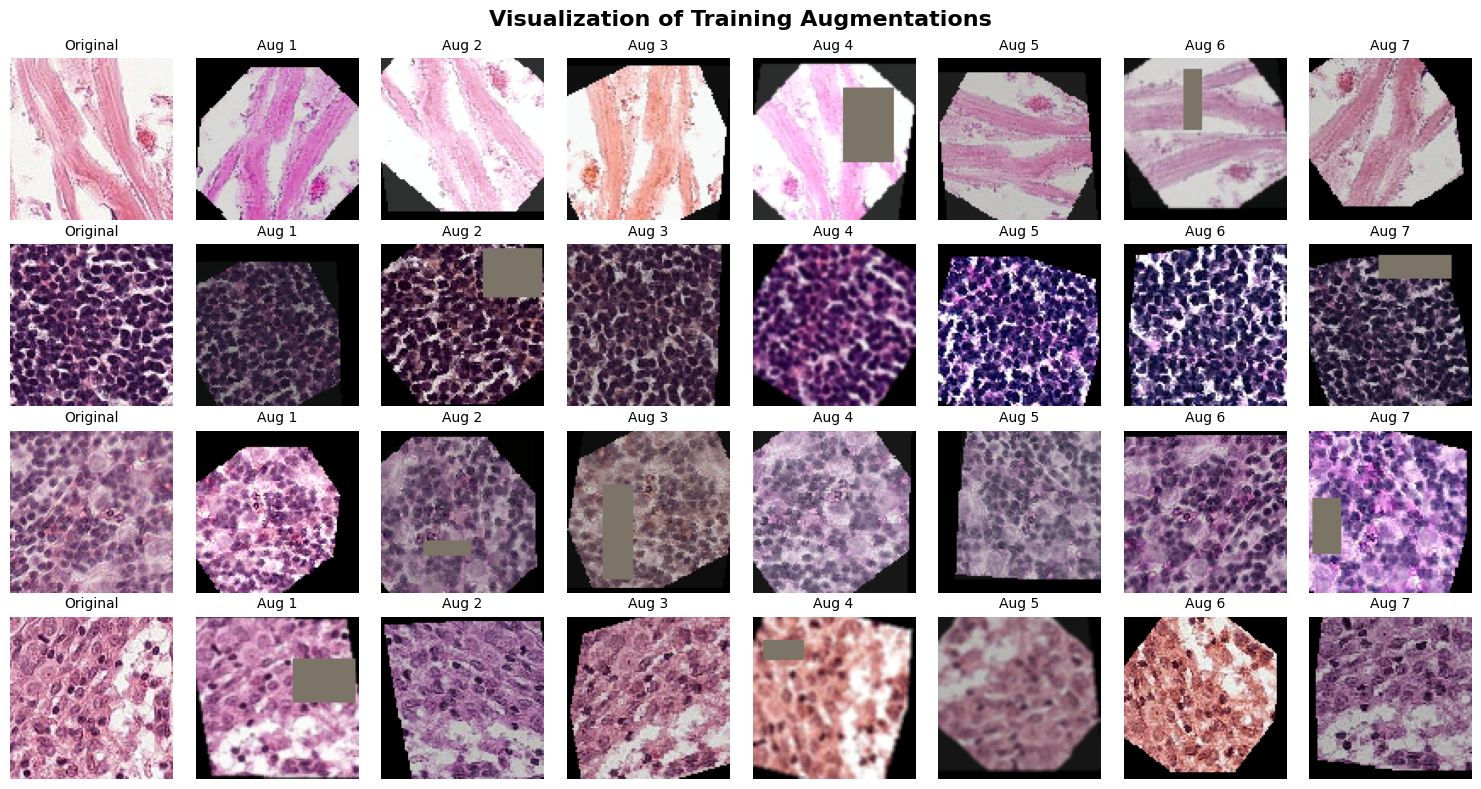

In [11]:
import matplotlib.pyplot as plt
import numpy as np

#sample 2 normal and 2 tumor images
sample_normal = train_labels[train_labels['label']==0].sample(2, random_state=42)
sample_tumor = train_labels[train_labels['label']==1].sample(2, random_state=42)
sample_df = pd.concat([sample_normal, sample_tumor])

train_transform = get_train_transforms()

fig, axes = plt.subplots(len(sample_df), 8, figsize=(15, 8))
fig.suptitle('Visualization of Training Augmentations', fontsize=16, fontweight='bold')

for i, (_, row) in enumerate(sample_df.iterrows()):
    img_path = os.path.join(CFG.train_dir, f"{row['id']}.tif")
    image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    
    axes[i, 0].imshow(image)
    axes[i, 0].set_title('Original', fontsize=10)
    axes[i, 0].axis('off')
    
    for j in range(1, 8):
        aug_img = train_transform(image).permute(1, 2, 0).numpy()
        
        # Undo normalization 
        aug_img = aug_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        aug_img = np.clip(aug_img, 0, 1)
        
        axes[i, j].imshow(aug_img)
        axes[i, j].set_title(f'Aug {j}', fontsize=10)
        axes[i, j].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


# Data Preparation
The dataset is split into training and validation sets (80% / 20%). The fraction of the data can be sampled for faster experiments, otherwise the model training on the whole dataset will be quite time consuming. 


In [12]:

train_df_all, val_df_all = train_test_split(
    train_labels, test_size=0.2, random_state=42, stratify=train_labels['label']
)

sampleFraction = 1

train_df = train_df_all.sample(frac=sampleFraction, random_state=42)
val_df = val_df_all.sample(frac=sampleFraction, random_state=42)


train_dataset = CancerDataset(train_df, CFG.train_dir, get_train_transforms())
val_dataset = CancerDataset(val_df, CFG.train_dir, get_val_transforms())

train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=False, pin_memory=False)




## User Apple mps backend for training

In [13]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')


## Model comparision between densenet121, resnet18 and efficientnet_b0

In this project, I compared three deep learning models — DenseNet121, ResNet18, and EfficientNet-B0 — to see which performs best for binary image classification. All models were fine-tuned using the same training setup, including learning rate scheduling, early stopping, and metric tracking to ensure a fair comparison. 

Each model has its own design philosophy, DenseNet connects every layer to all others, ResNet uses skip connections to solve vanishing gradients, and EfficientNet scales depth and width efficiently for better performance with fewer parameters.

From the experiments, DenseNet121 achieved the highest AUC and accuracy, showing strong feature extraction capability. ResNet18 is stable but slightly less accurate, while EfficientNet-B0 offered the best trade-off between speed and performance due to its lightweight design. Overall, DenseNet121 stood out as the most effective model for this cancer image classification task.

In [ ]:
import timm
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau
import time
from collections import defaultdict

# Define different model architectures for comparison
def create_model(model_name, num_classes=1, dropout_rate=0.3):
    if model_name == 'densenet121':
        model = models.densenet121(pretrained=True)
        num_features = model.classifier.in_features
        model.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate/2),
            nn.Linear(512, num_classes)
        )
    elif model_name == 'resnet18':
        model = models.resnet18(pretrained=True)
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate/2),
            nn.Linear(512, num_classes)
        )
    elif model_name == 'efficientnet_b0':
        model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=num_classes)
    return model

class ExperimentTrainer:
    def __init__(self, model, criterion, optimizer, scheduler, device, experiment_name):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.experiment_name = experiment_name
        self.history = {'train_loss': [], 'train_auc': [], 'val_loss': [], 'val_auc': []}
        
    def train_experiment(self, train_loader, val_loader, epochs=5, patience=3):
        best_auc = 0.0
        best_model_wts = None
        patience_counter = 0
        start_time = time.time()
        
        print(f"Starting experiment: {self.experiment_name}")
        
        for epoch in range(epochs):
            # Training
    
            self.model.train()
            train_loss, train_auc = self._train_epoch(train_loader)
            
            # Validation
            val_loss, val_auc, val_preds, val_labels = self._validate_epoch(val_loader)
            
            # Update scheduler
            if isinstance(self.scheduler, ReduceLROnPlateau):
                self.scheduler.step(val_loss)
            else:
                self.scheduler.step()
            
            # Save history
            self.history['train_loss'].append(train_loss)
            self.history['train_auc'].append(train_auc)
            self.history['val_loss'].append(val_loss)
            self.history['val_auc'].append(val_auc)
            
            print(f"Epoch {epoch+1}: Train AUC: {train_auc:.4f}, Val AUC: {val_auc:.4f}")
            
            # Early stopping
            if val_auc > best_auc:
                best_auc = val_auc
                best_model_wts = self.model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
        
        training_time = time.time() - start_time
        
        # Load best model
        if best_model_wts is not None:
            self.model.load_state_dict(best_model_wts)
        
        # Calculate final metrics
        final_metrics = self._calculate_final_metrics(val_loader)
        
        return {
            'experiment_name': self.experiment_name,
            'best_auc': best_auc,
            'training_time': training_time,
            'epochs_trained': len(self.history['train_loss']),
            'final_metrics': final_metrics,
            'history': self.history.copy()
        }
    
    def _train_epoch(self, train_loader):
        running_loss = 0.0
        preds_all, labels_all = [], []
        
        for images, labels in train_loader:
            images = images.to(self.device)
            labels = labels.to(self.device).unsqueeze(1)
            
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            preds_all.extend(preds.flatten())
            labels_all.extend(labels.cpu().numpy().flatten())
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_auc = roc_auc_score(labels_all, preds_all)
        return epoch_loss, epoch_auc
    
    def _validate_epoch(self, val_loader):
        self.model.eval()
        running_loss = 0.0
        preds_all, labels_all = [], []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(self.device)
                labels = labels.to(self.device).unsqueeze(1)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item() * images.size(0)
                preds = torch.sigmoid(outputs).cpu().numpy()
                preds_all.extend(preds.flatten())
                labels_all.extend(labels.cpu().numpy().flatten())
        
        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_auc = roc_auc_score(labels_all, preds_all)
        return epoch_loss, epoch_auc, preds_all, labels_all
    
    def _calculate_final_metrics(self, val_loader):
        self.model.eval()
        preds_all, labels_all = [], []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(self.device)
                labels = labels.to(self.device).unsqueeze(1)
                outputs = self.model(images)
                preds = torch.sigmoid(outputs).cpu().numpy()
                preds_all.extend(preds.flatten())
                labels_all.extend(labels.cpu().numpy().flatten())
        
        # Find optimal threshold
        thresholds = np.arange(0.3, 0.7, 0.01)
        best_threshold = 0.5
        best_acc = 0.0
        
        for thresh in thresholds:
            preds_binary = (np.array(preds_all) > thresh).astype(int)
            acc = accuracy_score(labels_all, preds_binary)
            if acc > best_acc:
                best_acc = acc
                best_threshold = thresh
        
        # Calculate metrics with optimal threshold
        preds_binary = (np.array(preds_all) > best_threshold).astype(int)
        cm = confusion_matrix(labels_all, preds_binary)
        report = classification_report(labels_all, preds_binary, 
                                     target_names=['Normal', 'Tumor'], output_dict=True)
        
        return {
            'accuracy': best_acc,
            'threshold': best_threshold,
            'precision_tumor': report['Tumor']['precision'],
            'recall_tumor': report['Tumor']['recall'],
            'f1_tumor': report['Tumor']['f1-score'],
            'confusion_matrix': cm
        }



In [35]:

architectures = ['densenet121', 'resnet18', 'efficientnet_b0']
architecture_results = []

# Use smaller sample 0.1 for faster experiments
sample_fraction = 0.1
train_df_sample = train_df.sample(frac=sample_fraction, random_state=42)
val_df_sample = val_df.sample(frac=sample_fraction, random_state=42)

train_dataset_sample = CancerDataset(train_df_sample, CFG.train_dir, get_train_transforms())
val_dataset_sample = CancerDataset(val_df_sample, CFG.train_dir, get_val_transforms())

train_loader_sample = DataLoader(train_dataset_sample, batch_size=64, shuffle=True)
val_loader_sample = DataLoader(val_dataset_sample, batch_size=64, shuffle=False)

print(f"Dataset: Train={len(train_df_sample)}, Val={len(val_df_sample)} | Epochs=3 | Sample={sample_fraction*100}%")

for i, arch in enumerate(architectures, 1):
    print(f"\n[{i}/{len(architectures)}] Testing: {arch.upper()}")
    

    model_exp = create_model(arch, dropout_rate=0.3).to(device)
    
    total_params = sum(p.numel() for p in model_exp.parameters())
    trainable_params = sum(p.numel() for p in model_exp.parameters() if p.requires_grad)
    
    print(f"Parameters: {total_params:,}")
    
    criterion_exp = nn.BCEWithLogitsLoss()
    optimizer_exp = torch.optim.AdamW(model_exp.parameters(), lr=3e-4, weight_decay=0.01)
    scheduler_exp = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer_exp, T_0=5, T_mult=1, eta_min=1e-6
    )
    
    trainer_exp = ExperimentTrainer(
        model_exp, criterion_exp, optimizer_exp, scheduler_exp, 
        device, f"Architecture_{arch}"
    )
    
    print(f"Training...", end=" ", flush=True)
    result = trainer_exp.train_experiment(
        train_loader_sample, val_loader_sample, epochs=3, patience=1)
    
    result['architecture'] = arch
    result['total_params'] = total_params
    result['trainable_params'] = trainable_params
    
    architecture_results.append(result)
    
    print(f"AUC: {result['best_auc']:.4f} | Time: {result['training_time']:.1f}s")
    


Dataset: Train=17602, Val=4400 | Epochs=3 | Sample=10.0%

[1/3] Testing: DENSENET121
Parameters: 7,480,193
Training... Starting experiment: Architecture_densenet121
Epoch 1: Train AUC: 0.9010, Val AUC: 0.9472
Epoch 2: Train AUC: 0.9317, Val AUC: 0.9591
Epoch 3: Train AUC: 0.9416, Val AUC: 0.9618
AUC: 0.9618 | Time: 246.7s

[2/3] Testing: RESNET18
Parameters: 11,440,705
Training... Starting experiment: Architecture_resnet18
Epoch 1: Train AUC: 0.8906, Val AUC: 0.9417
Epoch 2: Train AUC: 0.9191, Val AUC: 0.9558
Epoch 3: Train AUC: 0.9312, Val AUC: 0.9583
AUC: 0.9583 | Time: 141.0s

[3/3] Testing: EFFICIENTNET_B0
Parameters: 4,008,829
Training... Starting experiment: Architecture_efficientnet_b0
Epoch 1: Train AUC: 0.8076, Val AUC: 0.8526
Epoch 2: Train AUC: 0.8674, Val AUC: 0.9078
Epoch 3: Train AUC: 0.9006, Val AUC: 0.9308
AUC: 0.9308 | Time: 189.9s


## Optimizer comparison

This script tests four optimizers, Adam, AdamW, SGD, and RMSprop, on the selcted DenseNet121 model. Each optimizer is trained for 3 epochs with a learning rate of 3e-4, using BCE loss and cosine scheduler. The best AUC and training time are recorded to compare optimizer performance.

Observations:

AdamW achieved the highest validation AUC (0.9648), suggesting it is the most effective optimizer for this task in terms of convergence and generalization.

RMSprop showed instability during early epochs but recovered by epoch 3.

SGD converged slower and achieved lower AUC, likely due to the relatively high learning rate and short training duration.

Adam provided good performance but slightly underperformed compared to AdamW, possibly because AdamW handles weight decay more effectively.

In [16]:

optimizer_configs = ['Adam', 'AdamW', 'SGD', 'RMSprop']
optimizer_results = []


for i, optimizer_name in enumerate(optimizer_configs, 1):
    print(f"\n[{i}/{len(optimizer_configs)}] Testing: {optimizer_name}")
    
    model_exp = create_model('densenet121', dropout_rate=0.3).to(device)
    
    # Setup optimizer
    if optimizer_name == 'Adam':
        optimizer_exp = torch.optim.Adam(model_exp.parameters(), lr=3e-4, weight_decay=0.01)
    elif optimizer_name == 'AdamW':
        optimizer_exp = torch.optim.AdamW(model_exp.parameters(), lr=3e-4, weight_decay=0.01)
    elif optimizer_name == 'SGD':
        optimizer_exp = torch.optim.SGD(model_exp.parameters(), lr=3e-4, momentum=0.9, weight_decay=0.01)
    elif optimizer_name == 'RMSprop':
        optimizer_exp = torch.optim.RMSprop(model_exp.parameters(), lr=3e-4, weight_decay=0.01)
    
    criterion_exp = nn.BCEWithLogitsLoss()
    scheduler_exp = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer_exp, T_0=5, T_mult=1, eta_min=1e-6
    )
    
    trainer_exp = ExperimentTrainer(
        model_exp, criterion_exp, optimizer_exp, scheduler_exp, 
        device, f"Optimizer_{optimizer_name}"
    )
    
    print(f"Training...", end=" ", flush=True)
    result = trainer_exp.train_experiment(
        train_loader_sample, val_loader_sample, epochs=3, patience=3
    )
    
    result['optimizer'] = optimizer_name
    
    optimizer_results.append(result)
    
    print(f"AUC: {result['best_auc']:.4f} | Time: {result['training_time']:.1f}s")
        



[1/4] Testing: Adam
Training... Starting experiment: Optimizer_Adam
Epoch 1: Train AUC: 0.8936, Val AUC: 0.9415
Epoch 2: Train AUC: 0.9167, Val AUC: 0.9378
Epoch 3: Train AUC: 0.9249, Val AUC: 0.9381
AUC: 0.9415 | Time: 236.0s

[2/4] Testing: AdamW
Training... Starting experiment: Optimizer_AdamW
Epoch 1: Train AUC: 0.9004, Val AUC: 0.9450
Epoch 2: Train AUC: 0.9313, Val AUC: 0.9599
Epoch 3: Train AUC: 0.9434, Val AUC: 0.9648
AUC: 0.9648 | Time: 237.0s

[3/4] Testing: SGD
Training... Starting experiment: Optimizer_SGD
Epoch 1: Train AUC: 0.7432, Val AUC: 0.8765
Epoch 2: Train AUC: 0.8618, Val AUC: 0.9027
Epoch 3: Train AUC: 0.8824, Val AUC: 0.9145
AUC: 0.9145 | Time: 231.2s

[4/4] Testing: RMSprop
Training... Starting experiment: Optimizer_RMSprop
Epoch 1: Train AUC: 0.8592, Val AUC: 0.9105
Epoch 2: Train AUC: 0.8939, Val AUC: 0.6024
Epoch 3: Train AUC: 0.9092, Val AUC: 0.9478
AUC: 0.9478 | Time: 233.5s


# DenseNet121 Model for Cancer Detection
For this project, I used DenseNet121 as the backbone of my model because it’s very effective at capturing fine-grained patterns in images, which is essential for detecting cancer in tissue samples. It's also proved to have the best validation accuracy comparing to other models. I believe this is due to its dense connections.

I started with a pretrained DenseNet121 to leverage the rich feature representations learned from ImageNet, which helps the model generalize better with limited medical data. 

DenseNet121 consists of 121 layers organized into dense blocks separated by transition layers. Each layer receives input from all preceding layers within the same block, which encourages feature reuse and improves gradient flow during training. This design reduces the risk of vanishing gradients, allows for fewer parameters compared to other deep networks, and promotes efficient learning. The dense connections also encourage the network to learn complementary features, which is critical in medical image analysis where subtle differences matter.

On top of the DenseNet, I added a small classifier consisting of dropout, batch normalization, a ReLU activation, and a linear layer to adapt the model for binary cancer detection. The dense connections in DenseNet allow features to be reused across layers, improving gradient flow and learning efficiency, while the classifier head helps prevent overfitting and fine-tunes the model for this specific task.

Overall, this architecture balances performance, training efficiency, and overfitting control, making it well suited for histopathologic image classification.

The model has a total of 7,480,193 parameters.


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models



class DenseNet121Cancer(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Load pre-trained DenseNet121
        self.densenet = models.densenet121(pretrained=True)
        num_features = self.densenet.classifier.in_features
        
        self.densenet.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(), 
            nn.Dropout(0.25),
            nn.Linear(512, 1)
        )
        # self.densenet.classifier = nn.Linear(num_features, 1)


        #Freeze the denseblock1 layer
        # for name, param in self.densenet.features.named_parameters():
        #     # print("name:", name)
        #     if "denseblock1" in name or "denseblock2" in name:
        #         param.requires_grad = False
    
    def forward(self, x):
        return self.densenet(x)


model = DenseNet121Cancer().to(device)


total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(model)




Total Parameters: 7,480,193
Trainable Parameters: 7,480,193
DenseNet121Cancer(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): 

# Trainer Class
The Trainer class manages the training and validation loops for the model.  

- train_epoch sets the model to training mode, computes the loss with BCEWithLogitsLoss, backpropagates gradients, updates parameters, and collects predictions and labels to calculate the epoch AUC.  
- validate_epoch sets the model to evaluation mode, disables gradient computation, calculates the loss and AUC, and returns predictions and labels for further analysis.  

Sigmoid function is used to output the probility of the predict result.

This structure keeps the training workflow organized and makes it easy to track performance metrics at each epoch.


In [21]:
class Trainer:
    def __init__(self, model, criterion, optimizer, scheduler, device):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
    
    def train_epoch(self, train_loader):
        self.model.train()
        running_loss = 0.0
        preds_all, labels_all = [], []
        
        for images, labels in tqdm(train_loader, desc='Training'):
            images = images.to(self.device)
            labels = labels.to(self.device).unsqueeze(1)
            
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            preds_all.extend(preds.flatten())
            labels_all.extend(labels.cpu().numpy().flatten())
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_auc = roc_auc_score(labels_all, preds_all)
        return epoch_loss, epoch_auc
    
    def validate_epoch(self, val_loader):
        self.model.eval()
        running_loss = 0.0
        preds_all, labels_all = [], []
        
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc='Validation'):
                images = images.to(self.device)
                labels = labels.to(self.device).unsqueeze(1)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item() * images.size(0)
                preds = torch.sigmoid(outputs).cpu().numpy()
                preds_all.extend(preds.flatten())
                labels_all.extend(labels.cpu().numpy().flatten())
        
        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_auc = roc_auc_score(labels_all, preds_all)
        return epoch_loss, epoch_auc, preds_all, labels_all



## Trainer setup

In [36]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=CFG.epochs, T_mult=1, eta_min=1e-6
)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.5)


trainer = Trainer(model, criterion, optimizer, scheduler, device)

print(f"Train samples: {len(train_df):,}")
print(f"Val samples: {len(val_df):,}")

Train samples: 176,020
Val samples: 44,005


# Model Training, Early Stopping, and Evaluation
The training loop runs for a maximum of 20 epochs, tracking training and validation loss and AUC. Early stopping is applied with a patience of 5 epochs to prevent overfitting.

After training, the best model weights are loaded, and an optimal threshold for converting predicted probabilities to binary labels is determined by testing thresholds from 0.3 to 0.7 and selecting the one with the highest accuracy.  

The model is then saved (`model_best.pth`), and detailed evaluation metrics are computed, including confusion matrix, accuracy, precision, recall, and F1-score for both Normal and Tumor classes. This workflow ensures robust model selection and performance reporting.


In [23]:
best_auc = 0.0
best_model_wts = None
history = {'train_loss': [], 'train_auc': [], 'val_loss': [], 'val_auc': []}
patience = 5
patience_counter = 0

for epoch in range(CFG.epochs):
    print(f"Epoch {epoch + 1}/{CFG.epochs}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    train_loss, train_auc = trainer.train_epoch(train_loader)
    
    val_loss, val_auc, val_preds, val_labels = trainer.validate_epoch(val_loader)
    
    scheduler.step()
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_auc'].append(train_auc)
    history['val_loss'].append(val_loss)
    history['val_auc'].append(val_auc)
    
    print(f"Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")
    
    # Save best model
    if val_auc > best_auc:
        best_auc = val_auc
        best_model_wts = model.state_dict().copy()
        patience_counter = 0
        print(f"Best AUC improved to {best_auc:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break

model.load_state_dict(best_model_wts)

# Find the best threshold
thresholds = np.arange(0.3, 0.7, 0.01)
best_threshold = 0.5
best_acc = 0.0

for thresh in thresholds:
    preds_binary = (np.array(val_preds) > thresh).astype(int)
    acc = accuracy_score(val_labels, preds_binary)
    if acc > best_acc:
        best_acc = acc
        best_threshold = thresh

print(f"Optimal Threshold: {best_threshold:.3f}, Best Accuracy: {best_acc:.4f}")

torch.save(model.state_dict(), 'model_best.pth')
print("Model saved: model_best.pth")

# Generate detailed metrics
final_preds_binary = (np.array(val_preds) > best_threshold).astype(int)
cm = confusion_matrix(val_labels, final_preds_binary)
report = classification_report(val_labels, final_preds_binary, 
                               target_names=['Normal', 'Tumor'], output_dict=True)

print(f"Best Validation AUC: {best_auc:.4f}")
print(f"Validation Accuracy: {best_acc:.4f}")
print(f"Precision (Normal): {report['Normal']['precision']:.4f}")
print(f"Precision (Tumor): {report['Tumor']['precision']:.4f}")
print(f"Recall (Normal): {report['Normal']['recall']:.4f}")
print(f"Recall (Tumor): {report['Tumor']['recall']:.4f}")
print(f"F1-Score (Normal): {report['Normal']['f1-score']:.4f}")
print(f"F1-Score (Tumor): {report['Tumor']['f1-score']:.4f}")


Epoch 1/20
Learning Rate: 0.000300


Training:   0%|          | 0/1376 [00:00<?, ?it/s]

Validation:   0%|          | 0/344 [00:00<?, ?it/s]

Train Loss: 0.2853, Train AUC: 0.9459
Val Loss: 0.1764, Val AUC: 0.9781
Best AUC improved to 0.9781
Epoch 2/20
Learning Rate: 0.000298


Training:   0%|          | 0/1376 [00:00<?, ?it/s]

Validation:   0%|          | 0/344 [00:00<?, ?it/s]

Train Loss: 0.2333, Train AUC: 0.9633
Val Loss: 0.1537, Val AUC: 0.9831
Best AUC improved to 0.9831
Epoch 3/20
Learning Rate: 0.000293


Training:   0%|          | 0/1376 [00:00<?, ?it/s]

Validation:   0%|          | 0/344 [00:00<?, ?it/s]

Train Loss: 0.2163, Train AUC: 0.9684
Val Loss: 0.1455, Val AUC: 0.9851
Best AUC improved to 0.9851
Epoch 4/20
Learning Rate: 0.000284


Training:   0%|          | 0/1376 [00:00<?, ?it/s]

Validation:   0%|          | 0/344 [00:00<?, ?it/s]

Train Loss: 0.2052, Train AUC: 0.9713
Val Loss: 0.1813, Val AUC: 0.9786
Epoch 5/20
Learning Rate: 0.000271


Training:   0%|          | 0/1376 [00:00<?, ?it/s]

Validation:   0%|          | 0/344 [00:00<?, ?it/s]

Train Loss: 0.1928, Train AUC: 0.9744
Val Loss: 0.1431, Val AUC: 0.9854
Best AUC improved to 0.9854
Epoch 6/20
Learning Rate: 0.000256


Training:   0%|          | 0/1376 [00:00<?, ?it/s]

Validation:   0%|          | 0/344 [00:00<?, ?it/s]

Train Loss: 0.1843, Train AUC: 0.9767
Val Loss: 0.1272, Val AUC: 0.9880
Best AUC improved to 0.9880
Epoch 7/20
Learning Rate: 0.000238


Training:   0%|          | 0/1376 [00:00<?, ?it/s]

Validation:   0%|          | 0/344 [00:00<?, ?it/s]

Train Loss: 0.1744, Train AUC: 0.9789
Val Loss: 0.1272, Val AUC: 0.9890
Best AUC improved to 0.9890
Epoch 8/20
Learning Rate: 0.000218


Training:   0%|          | 0/1376 [00:00<?, ?it/s]

Validation:   0%|          | 0/344 [00:00<?, ?it/s]

Train Loss: 0.1681, Train AUC: 0.9804
Val Loss: 0.1099, Val AUC: 0.9909
Best AUC improved to 0.9909
Epoch 9/20
Learning Rate: 0.000197


Training:   0%|          | 0/1376 [00:00<?, ?it/s]

Validation:   0%|          | 0/344 [00:00<?, ?it/s]

Train Loss: 0.1592, Train AUC: 0.9823
Val Loss: 0.1132, Val AUC: 0.9904
Epoch 10/20
Learning Rate: 0.000174


Training:   0%|          | 0/1376 [00:00<?, ?it/s]

Validation:   0%|          | 0/344 [00:00<?, ?it/s]

Train Loss: 0.1526, Train AUC: 0.9837
Val Loss: 0.1100, Val AUC: 0.9910
Best AUC improved to 0.9910
Epoch 11/20
Learning Rate: 0.000150


Training:   0%|          | 0/1376 [00:00<?, ?it/s]

Validation:   0%|          | 0/344 [00:00<?, ?it/s]

Train Loss: 0.1458, Train AUC: 0.9850
Val Loss: 0.1044, Val AUC: 0.9922
Best AUC improved to 0.9922
Epoch 12/20
Learning Rate: 0.000127


Training:   0%|          | 0/1376 [00:00<?, ?it/s]

Validation:   0%|          | 0/344 [00:00<?, ?it/s]

Train Loss: 0.1381, Train AUC: 0.9866
Val Loss: 0.0970, Val AUC: 0.9927
Best AUC improved to 0.9927
Epoch 13/20
Learning Rate: 0.000104


Training:   0%|          | 0/1376 [00:00<?, ?it/s]

Validation:   0%|          | 0/344 [00:00<?, ?it/s]

Train Loss: 0.1307, Train AUC: 0.9880
Val Loss: 0.0965, Val AUC: 0.9930
Best AUC improved to 0.9930
Epoch 14/20
Learning Rate: 0.000083


Training:   0%|          | 0/1376 [00:00<?, ?it/s]

Validation:   0%|          | 0/344 [00:00<?, ?it/s]

Train Loss: 0.1246, Train AUC: 0.9890
Val Loss: 0.0907, Val AUC: 0.9938
Best AUC improved to 0.9938
Epoch 15/20
Learning Rate: 0.000063


Training:   0%|          | 0/1376 [00:00<?, ?it/s]

Validation:   0%|          | 0/344 [00:00<?, ?it/s]

Train Loss: 0.1194, Train AUC: 0.9899
Val Loss: 0.0887, Val AUC: 0.9942
Best AUC improved to 0.9942
Epoch 16/20
Learning Rate: 0.000045


Training:   0%|          | 0/1376 [00:00<?, ?it/s]

Validation:   0%|          | 0/344 [00:00<?, ?it/s]

Train Loss: 0.1144, Train AUC: 0.9907
Val Loss: 0.0852, Val AUC: 0.9945
Best AUC improved to 0.9945
Epoch 17/20
Learning Rate: 0.000030


Training:   0%|          | 0/1376 [00:00<?, ?it/s]

Validation:   0%|          | 0/344 [00:00<?, ?it/s]

Train Loss: 0.1084, Train AUC: 0.9916
Val Loss: 0.0827, Val AUC: 0.9949
Best AUC improved to 0.9949
Epoch 18/20
Learning Rate: 0.000017


Training:   0%|          | 0/1376 [00:00<?, ?it/s]

Validation:   0%|          | 0/344 [00:00<?, ?it/s]

Train Loss: 0.1062, Train AUC: 0.9919
Val Loss: 0.0815, Val AUC: 0.9950
Best AUC improved to 0.9950
Epoch 19/20
Learning Rate: 0.000008


Training:   0%|          | 0/1376 [00:00<?, ?it/s]

Validation:   0%|          | 0/344 [00:00<?, ?it/s]

Train Loss: 0.1048, Train AUC: 0.9922
Val Loss: 0.0821, Val AUC: 0.9950
Best AUC improved to 0.9950
Epoch 20/20
Learning Rate: 0.000003


Training:   0%|          | 0/1376 [00:00<?, ?it/s]

Validation:   0%|          | 0/344 [00:00<?, ?it/s]

Train Loss: 0.1024, Train AUC: 0.9925
Val Loss: 0.0805, Val AUC: 0.9952
Best AUC improved to 0.9952
Optimal Threshold: 0.410, Best Accuracy: 0.9729
Model saved: model_best.pth
Best Validation AUC: 0.9952
Validation Accuracy: 0.9729
Precision (Normal): 0.9745
Precision (Tumor): 0.9705
Recall (Normal): 0.9801
Recall (Tumor): 0.9623
F1-Score (Normal): 0.9773
F1-Score (Tumor): 0.9664


Train Loss: 0.1028, Train AUC: 0.9924
Val Loss: 0.0810, Val AUC: 0.9950
Optimal Threshold: 0.450, Best Accuracy: 0.9727
Model saved: model_best.pth
Best Validation AUC: 0.9951
Validation Accuracy: 0.9727
Precision (Normal): 0.9720
Precision (Tumor): 0.9736
Recall (Normal): 0.9823
Recall (Tumor): 0.9585
F1-Score (Normal): 0.9771
F1-Score (Tumor): 0.9660


#Result analysis

The model achieves a best validation AUC of 0.9952, indicating near-perfect discrimination between classes. The training AUC reaches approximately 0.99 by epoch 20, while validation AUC plateaus around 0.995. Training and validation AUC curves show steady improvement, and started to converge at around epoch 18.

The confusion matrix shows that the model performs really well overall. For the Normal class, there are 25,661 true negatives and only 521 false positives, giving about 98.0% specificity. For the Tumor class, it got 17,151 true positives and 672 false negatives, which means around 96.2% sensitivity.

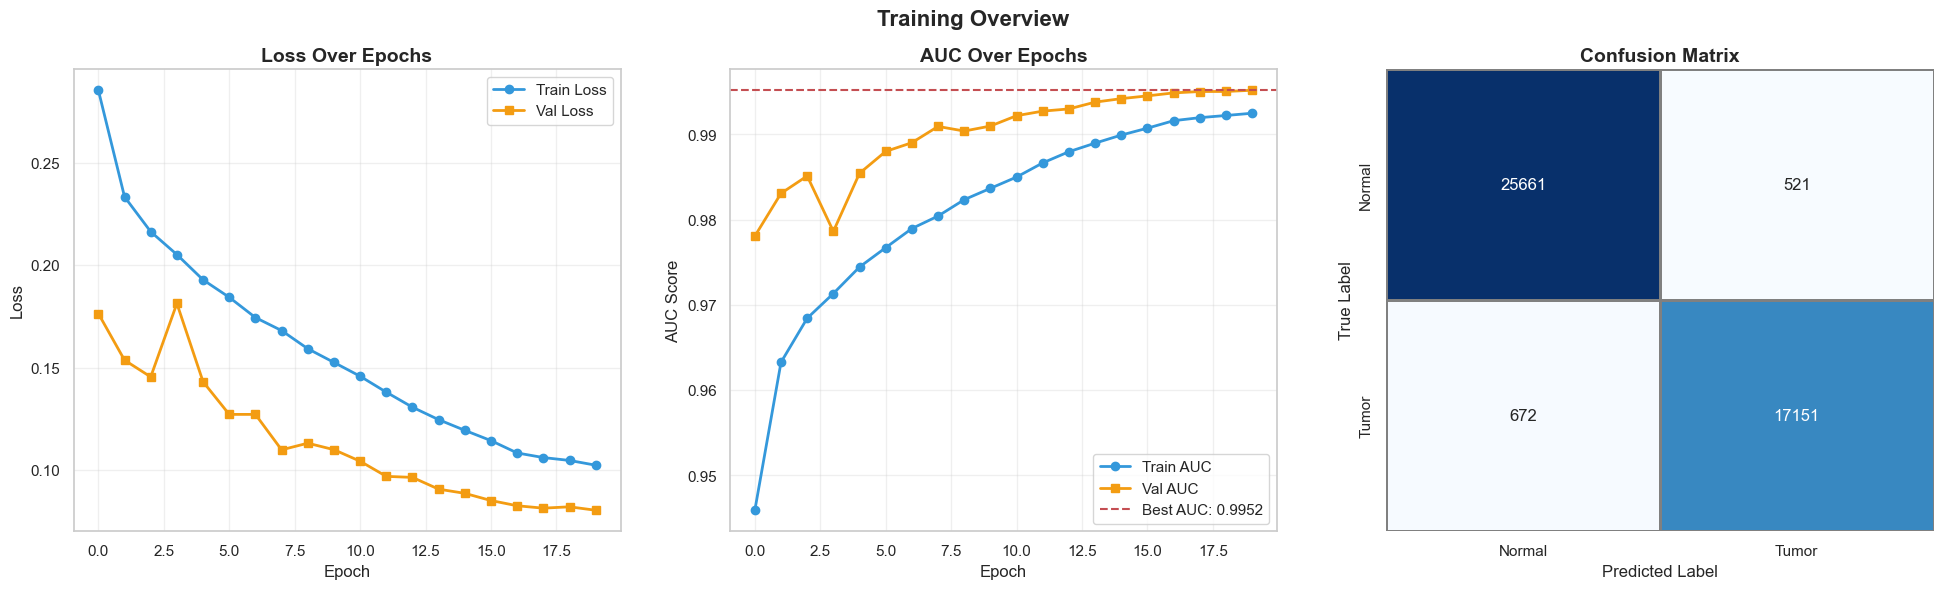

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score

sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12})


fig1, axs1 = plt.subplots(1, 3, figsize=(24, 6))

# 1. Loss Curve
axs1[0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2, color='#3498db')
axs1[0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2, color='#f39c12')
axs1[0].set_title('Loss Over Epochs', fontweight='bold', fontsize=14)
axs1[0].set_xlabel('Epoch')
axs1[0].set_ylabel('Loss')
axs1[0].legend()
axs1[0].grid(alpha=0.3)

# 2. AUC Curve
axs1[1].plot(history['train_auc'], label='Train AUC', marker='o', linewidth=2, color='#3498db')
axs1[1].plot(history['val_auc'], label='Val AUC', marker='s', linewidth=2, color='#f39c12')
axs1[1].axhline(y=best_auc, color='r', linestyle='--', label=f'Best AUC: {best_auc:.4f}')
axs1[1].set_title('AUC Over Epochs', fontweight='bold', fontsize=14)
axs1[1].set_xlabel('Epoch')
axs1[1].set_ylabel('AUC Score')
axs1[1].legend()
axs1[1].grid(alpha=0.3)

# 3. Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs1[2],
            xticklabels=['Normal', 'Tumor'], yticklabels=['Normal', 'Tumor'],
            cbar=False, linewidths=1, linecolor='gray')
axs1[2].set_title('Confusion Matrix', fontweight='bold', fontsize=14)
axs1[2].set_ylabel('True Label')
axs1[2].set_xlabel('Predicted Label')

plt.suptitle('Training Overview', fontsize=16, fontweight='bold')
plt.show()

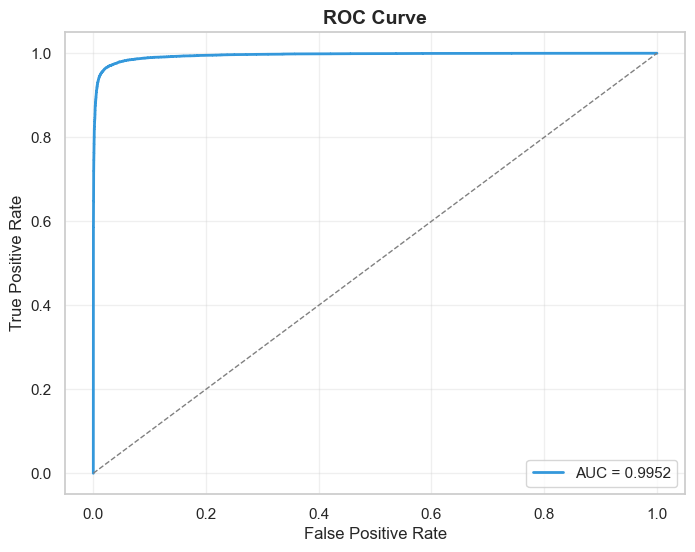

In [41]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

fpr, tpr, _ = roc_curve(val_labels, val_preds)
final_auc = roc_auc_score(val_labels, val_preds)

# Plot ROC–AUC curve
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#3498db', lw=2, label=f'AUC = {final_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


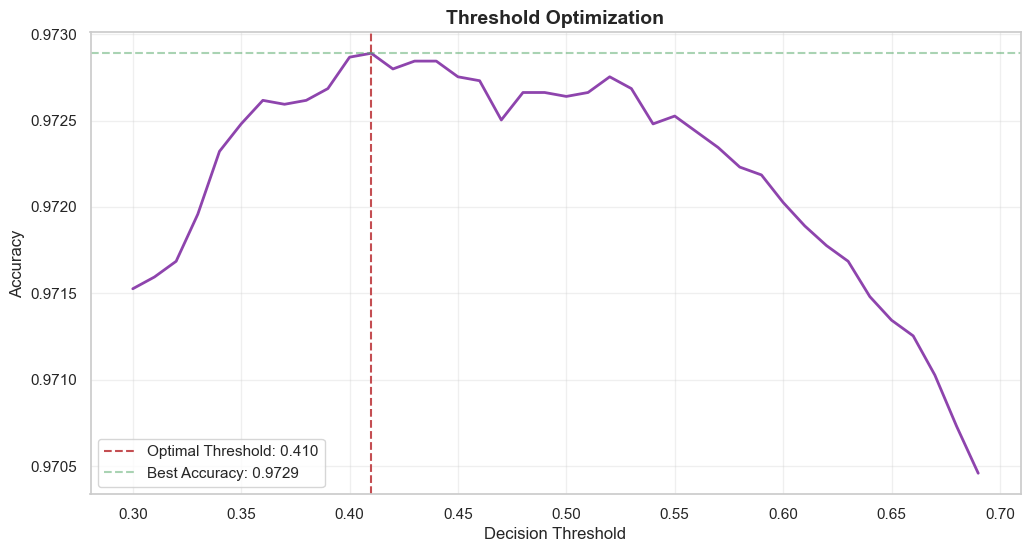

In [25]:
fig2, ax2 = plt.subplots(figsize=(12, 6))
threshold_range = np.arange(0.3, 0.7, 0.01)
accuracies = [accuracy_score(val_labels, (np.array(val_preds) > t).astype(int)) for t in threshold_range]

ax2.plot(threshold_range, accuracies, linewidth=2, color='#8e44ad')
ax2.axvline(best_threshold, color='r', linestyle='--', label=f'Optimal Threshold: {best_threshold:.3f}')
ax2.axhline(best_acc, color='g', linestyle='--', alpha=0.5, label=f'Best Accuracy: {best_acc:.4f}')
ax2.set_title('Threshold Optimization', fontweight='bold', fontsize=14)
ax2.set_xlabel('Decision Threshold')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)

plt.show()

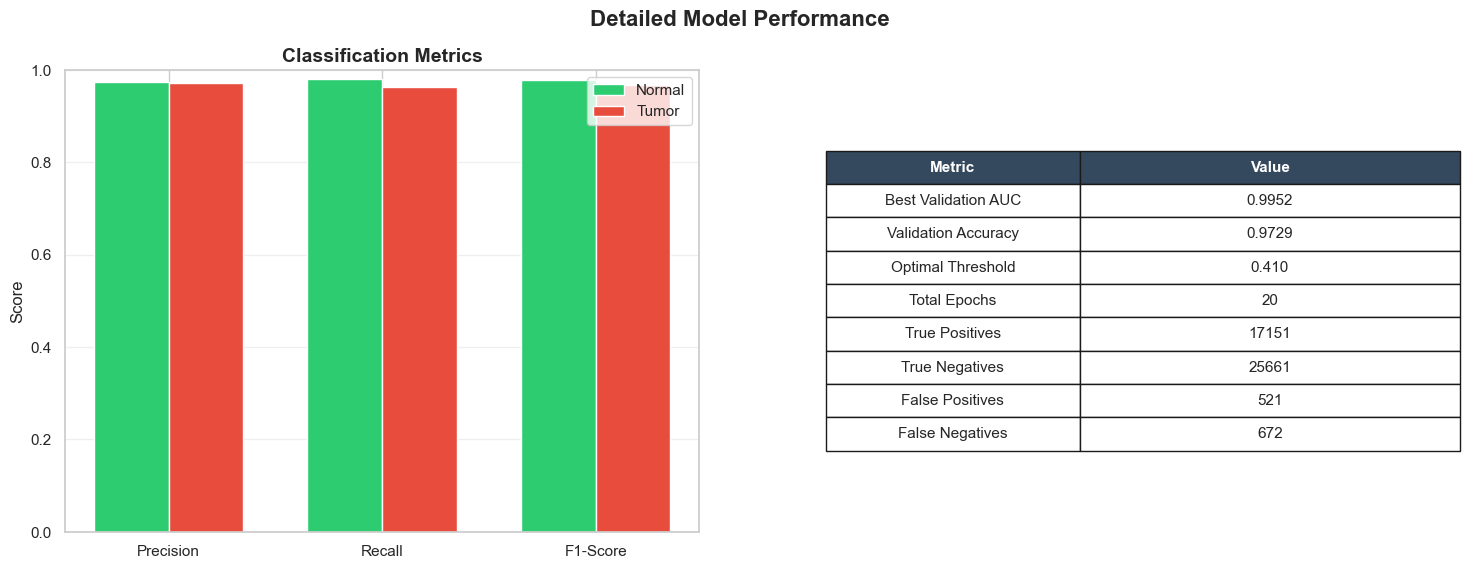

In [37]:
fig3, axs3 = plt.subplots(1, 2, figsize=(18, 6))

metrics = ['Precision', 'Recall', 'F1-Score']
normal_scores = [report['Normal']['precision'], report['Normal']['recall'], report['Normal']['f1-score']]
tumor_scores = [report['Tumor']['precision'], report['Tumor']['recall'], report['Tumor']['f1-score']]
x = np.arange(len(metrics))
width = 0.35

axs3[0].bar(x - width/2, normal_scores, width, label='Normal', color='#2ecc71')
axs3[0].bar(x + width/2, tumor_scores, width, label='Tumor', color='#e74c3c')
axs3[0].set_title('Classification Metrics', fontweight='bold', fontsize=14)
axs3[0].set_ylabel('Score')
axs3[0].set_xticks(x)
axs3[0].set_xticklabels(metrics)
axs3[0].set_ylim(0, 1)
axs3[0].legend()
axs3[0].grid(alpha=0.3, axis='y')

axs3[1].axis('off')
summary_data = [
    ['Metric', 'Value'],
    ['Best Validation AUC', f'{best_auc:.4f}'],
    ['Validation Accuracy', f'{best_acc:.4f}'],
    ['Optimal Threshold', f'{best_threshold:.3f}'],
    ['Total Epochs', f'{len(history["train_loss"])}'],
    ['True Positives', f'{cm[1,1]}'],
    ['True Negatives', f'{cm[0,0]}'],
    ['False Positives', f'{cm[0,1]}'],
    ['False Negatives', f'{cm[1,0]}'],
]

table = axs3[1].table(cellText=summary_data, colLabels=None, cellLoc='center', loc='center', colWidths=[0.4,0.6])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

for j in range(2):
    table[(0,j)].set_facecolor('#34495e')
    table[(0,j)].set_text_props(weight='bold', color='white')

plt.suptitle('Detailed Model Performance', fontsize=16, fontweight='bold')
plt.show()

In [27]:
import torch
import numpy as np
import pandas as pd
import os
import cv2
from tqdm import tqdm

def predict(model, image_paths, tta_transforms, batch_size=32):
    model.eval()
    predictions = []

    with torch.no_grad():
        for i in tqdm(range(0, len(image_paths), batch_size), desc='Predicting with TTA'):
            batch_paths = image_paths[i:i + batch_size]
            batch_tta_images = []

            # Prepare all TTA variants for each image in the batch
            for path in batch_paths:
                image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
                for transform in tta_transforms:
                    img_t = transform(image)
                    batch_tta_images.append(img_t)

            batch_tensor = torch.stack(batch_tta_images).to(device)

            # Forward pass
            outputs = model(batch_tensor)
            preds = torch.sigmoid(outputs).cpu().numpy().reshape(len(batch_paths), len(tta_transforms))

            # Average TTA predictions for each image
            batch_means = preds.mean(axis=1)
            predictions.extend(batch_means.tolist())

    return predictions


test_df = pd.read_csv(f'{CFG.data_dir}/sample_submission.csv')
print(f"Test samples: {len(test_df)}")

tta_transforms = get_tta_transforms()
image_paths = [os.path.join(CFG.test_dir, f"{img_id}.tif") for img_id in test_df['id']]


predictions = predict(model, image_paths, tta_transforms, batch_size=64)


submission = pd.DataFrame({
    'id': test_df['id'],
    'label': predictions
})

submission.to_csv('submission.csv', index=False)

print(f"  Mean: {np.mean(predictions):.4f}")
print(f"  Std: {np.std(predictions):.4f}")
print(f"  Min: {np.min(predictions):.4f}")
print(f"  Max: {np.max(predictions):.4f}")
print(f"  Predicted Positive Rate: {(np.array(predictions) > 0.5).mean()*100:.2f}%")


Test samples: 57458


Predicting with TTA: 100%|█████████████████████████████████████████████████████████████| 898/898 [04:57<00:00,  3.02it/s]


  Mean: 0.3400
  Std: 0.4332
  Min: 0.0000
  Max: 1.0000
  Predicted Positive Rate: 33.85%


## Summary:

In this project, I developed a deep learning model for histopathologic cancer detection using the DenseNet121 architecture. By leveraging transfer learning and advanced data augmentation techniques, the model achieved strong performance on the validation set.

I realized that medical imaging tasks benefit greatly from domain specific augmentations, such as rotations and color jitter, in order to account for real world variability in the data. 

I initially experimented with ResNet18, but switching to DenseNet121, which improved a lot for both performance and convergence. Additionally, test-time augmentation helped boost accuracy, while strategies like early stopping and learning rate scheduling effectively reduced overfitting.

## What helped improve performance:

Transfer learning from pretrained model helped improve the model’s performance by providing strong initial feature representations. This was particularly important because the dataset was relatively small, and starting from pretrained weights allowed the model to generalize better without overfitting to limited data.

Domain-specific data augmentation, including rotations, flips, and color jitter, also played a key role in improving performance. These augmentations exposed the model to a wider variety of tissue slide variations, helping it handle real world variability and improving its ability to generalize to unseen images.

Test-time augmentation (TTA) provided an additional boost in accuracy. By averaging predictions across multiple augmented versions of each image during inference, the model’s predictions became more robust and reliable.

Regularization techniques such as dropout, batch normalization, and early stopping were essential for preventing overfitting. Dropout helped the model avoid relying too heavily on specific neurons, batch normalization stabilized training, and early stopping ensured the model did not overfit the training data.

Finally, learning rate scheduling contributed to faster and more stable convergence. Adjusting the learning rate during training allowed the optimizer to make more efficient updates, improving overall performance and reducing the risk of getting stuck in local minimal.

## What did not help much

1. Trying more complex architectures beyond DenseNet121, like DenseNet201 or other models with more parameters, did not show significant improvement in the validation result,  it also slowed training without clear gains.

2. Increasing the amount of standard augmentation like the differen rotations or heavy color changes sometimes made training unstable and reduced validation performance.

## Future improvements and ideas:

1. Experimenting with ensembles of multiple models could improve robustness and final accuracy, but it will take more time for training multiple models, so it's not implemented in this assignment.

2. Exploring advanced augmentation methods such as MixUp or CutMix might help the model generalize even better. 

3. Using larger pretrained models like EfficientNet or vision transformers could capture more complex features, although they would require more computational resources.

4. Incorporating attention mechanisms might help the model focus on subtle regions of interest in tissue.

5. The training dataset could be further augmented by using test dataset images with high confidence predicited images.